# ECG (heart beat) classification problem 
Aim: Given a numerical signal (vector of numbers form) decide whether it is normal *N* or not - arrhythmia *S* or *V*. In this notebook no features are explicitly extractedm everything is performed on the sequence itself.

Checked models: Decision tree, AdaBoost, Random Forest, SVM, Naive Bayes, Different structures of DNN.

Done on the basis of dr Jarek Pawłowski notebook with tasks.

# Dataset preparation
1. Download ecg waves from **svdb** database provided by *PhysioNet*
2. Divide signals into samples, each containing single heartbeat (with window size of 96 points, *sampling ratio* = 128 points/s)
3. Take only samples annotated as 'N' (normal beat), or 'S' and 'V' (arrhythmias)

In [ ]:
import os
import numpy as np

# install PhysioNet ecg data package 
!pip install wfdb
import wfdb

# list of available datasets
dbs = wfdb.get_dbs()
display(dbs)

# we choose svdb
svdb_dir = os.path.join(os.getcwd(), 'svdb_dir')
wfdb.dl_database('svdb', dl_dir=svdb_dir)

# Display the  downloaded content
svdb_in_files = [os.path.splitext(f)[0] for f in os.listdir(svdb_dir) if f.endswith('.dat')]
print(svdb_in_files)

     |████████████████████████████████| 133kB 5.5MB/s 


[['aami-ec13', 'ANSI/AAMI EC13 Test Waveforms'],
 ['adfecgdb', 'Abdominal and Direct Fetal ECG Database'],
 ['afdb', 'MIT-BIH Atrial Fibrillation Database'],
 ['afpdb', 'PAF Prediction Challenge Database'],
 ['aftdb', 'AF Termination Challenge Database'],
 ['ahadb', 'AHA Database Sample Excluded Record'],
 ['antimicrobial-resistance-uti',
  'AMR-UTI: Antimicrobial Resistance in Urinary Tract Infections'],
 ['apnea-ecg', 'Apnea-ECG Database'],
 ['bhx-brain-bounding-box',
  'Brain Hemorrhage Extended (BHX): Bounding box extrapolation from thick to thin slice CT images'],
 ['bidmc', 'BIDMC PPG and Respiration Dataset'],
 ['bigideaslab-step-hr-smartwatch',
  'BigIdeasLab_STEP: Heart rate measurements captured by smartwatches for differing skin tones'],
 ['body-sway-music-vr',
  'Body Sway When Standing and Listening to Music Modified to Reinforce Virtual Reality Environment Motion'],
 ['bpssrat', 'Blood Pressure in Salt-Sensitive Dahl Rats'],
 ['but-pdb',
  'Brno University of Technology E

Generating record list for: 800
Generating record list for: 801
Generating record list for: 802
Generating record list for: 803
Generating record list for: 804
Generating record list for: 805
Generating record list for: 806
Generating record list for: 807
Generating record list for: 808
Generating record list for: 809
Generating record list for: 810
Generating record list for: 811
Generating record list for: 812
Generating record list for: 820
Generating record list for: 821
Generating record list for: 822
Generating record list for: 823
Generating record list for: 824
Generating record list for: 825
Generating record list for: 826
Generating record list for: 827
Generating record list for: 828
Generating record list for: 829
Generating record list for: 840
Generating record list for: 841
Generating record list for: 842
Generating record list for: 843
Generating record list for: 844
Generating record list for: 845
Generating record list for: 846
Generating record list for: 847
Generati

KeyboardInterrupt: ignored

In [ ]:
time_window = 48
all_beats = []
all_annotations = []
for in_file in svdb_in_files:
    print('...processing...' + in_file + '...file')
    signal, fields = wfdb.rdsamp(os.path.join(svdb_dir,in_file), channels=[0])
    annotations = wfdb.rdann(os.path.join(svdb_dir,in_file), 'atr')
    signal=np.array(signal).flatten()
    # grab subsequent heartbeats within [position-64,position+64] window
    beats = np.zeros((len(annotations.sample),time_window*2))
    # note that we remove first and last beats to ensure that all beats have equal lengths
    for i, ann_position in enumerate(annotations.sample[5:-5]):
        beats[i] = signal[ann_position-time_window:ann_position+time_window]
    all_beats.append(beats)
    # consequently, we remove few first and last annotations
    all_annotations.append(annotations.symbol[5:-5])

all_beats = np.concatenate(all_beats)
all_annotations = np.concatenate(all_annotations)

# check which annotations are usable for us, are of N or S or V class
indices = [i for i, ann in enumerate(all_annotations) if ann in {'N','S','V'}]
# and get only these
all_beats = all_beats[indices]
all_annotations = np.array([all_annotations[i] for i in indices])

# print data statistics
print(all_beats.shape, all_annotations.shape)
print('no of N beats: ' + str(np.count_nonzero(all_annotations == 'N')))
print('no of S beats: ' + str(np.count_nonzero(all_annotations == 'S')))
print('no of V beats: ' + str(np.count_nonzero(all_annotations == 'V')))

...processing...866...file
...processing...877...file
...processing...850...file
...processing...800...file
...processing...827...file
...processing...801...file
...processing...853...file
...processing...802...file
...processing...892...file
...processing...893...file
...processing...821...file
...processing...823...file
...processing...849...file
...processing...881...file
...processing...868...file
...processing...859...file
...processing...879...file
...processing...890...file
...processing...824...file
...processing...861...file
...processing...841...file
...processing...880...file
...processing...829...file
...processing...870...file
...processing...883...file
...processing...865...file
...processing...873...file
...processing...860...file
...processing...843...file
...processing...806...file
...processing...891...file
...processing...822...file
...processing...808...file
...processing...851...file
...processing...872...file
...processing...847...file
...processing...878...file
.

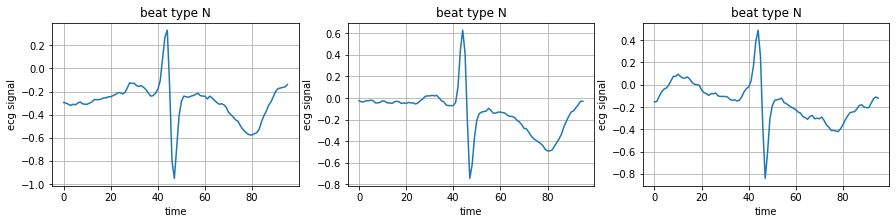

In [ ]:
# show example samples
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3)
fig.set_size_inches(15, 3)
plt.subplots_adjust(wspace=0.2)
sample_number = [200,298,996]

for i, sn in enumerate(sample_number):
    ax[i].plot(all_beats[sn])
    ax[i].set(xlabel='time', ylabel='ecg signal', title='beat type ' + all_annotations[sn])
    ax[i].grid()
plt.show()

# Experiments

0. Preliminaries
> - Divide dataset into train/validation/test subset, and normalize each of them. 
> - Define classification accuracy metrics (dataset is imbalanced)
>>Confusion matrix
```
____Prediction
T |   n  s  v
r |N  Nn Ns Nv
u |S  Sn Ss Sv
t |V  Vn Vs Vv
h | 
```
>> - Total accuracy
$Acc_T = \frac{Nn+Ss+Vv}{\Sigma_N+\Sigma_S+\Sigma_V}$,
>> - Arrhythmia accuracy (S or V cases are more important to be detected):
$Acc_A = \frac{Ss+Vv}{\Sigma_S+\Sigma_V}$,
>> - $\Sigma_N=Nn+Ns+Nv$, $\Sigma_S=Sn+Ss+Sv$,
$\Sigma_V=Vn+Vs+Vv$

1. Standard classifiers: *naive Bayes* and *SVM*
2. Decision Tree with optimized max_depth
3. Random Forest with vector of features

In [ ]:
# prepare datasets and define error metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# to simplify experiments and speedup training 
# we take only some part of the whole dataset
X, y = all_beats[::5], all_annotations[::5]

# train/validation/test set splitting 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85, random_state=0)
print(len(y_train), len(y_val), len(y_test))

# perform data normalization: z = (x - u)/s
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
# same for the validation subset
X_val = preprocessing.StandardScaler().fit_transform(X_val)
# and for the test subset
X_test = preprocessing.StandardScaler().fit_transform(X_test)

# define accuracy
def calculate_accuracy(y_pred, y_gt, comment='', printout=True):
    acc_t = np.count_nonzero(y_pred == y_gt)/len(y_gt)
    acc_a = np.count_nonzero(
        np.logical_and(y_pred == y_gt, y_gt != 'N'))/np.count_nonzero(y_gt != 'N')
    if printout is True:
        print('-----------------------------------')    
        print(comment)
        print('Total accuracy, Acc_T = {:.4f}'.format(acc_t))
        print('Arrhythmia accuracy, Acc_A = {:.4f}'.format(acc_a))
        print('-----------------------------------')
    else: return acc_t, acc_a 

25718 5512 5512


Perform oversampling

In [ ]:
dodatkowe = {'S':20000, 'V':20000}
while dodatkowe['S'] >0 or dodatkowe['V']>0:
  for i in range(len(y_train)):
    if  dodatkowe['S'] >0 and y_train[i] =="S":
      X_train = np.concatenate((X_train, [X_train[i]]), axis=0)
      y_train = np.concatenate((y_train, [y_train[i]]))
      dodatkowe['S']-=1
    if  dodatkowe['V'] >0 and y_train[i] =="V":
      X_train = np.concatenate((X_train, [X_train[i]]), axis=0)
      y_train = np.concatenate((y_train, [y_train[i]]))
      dodatkowe['V']-=1

counts = {'N':0, 'S':0, 'V':0}
for i in y_train:
  counts[i]+=1
print(counts)

{'N': 22629, 'S': 21700, 'V': 21389}


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(n_estimators=200)
y_pred = abc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='Ada with wavelets')

-----------------------------------
Ada with wavelets
Total accuracy, Acc_T = 0.5406
Arrhythmia accuracy, Acc_A = 0.4635
-----------------------------------


Deep NN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
model_args = {}
# random seed
model_args['seed'] = 123
# we will use batch size of 128 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 16
# learning rate is how fast it will descend
model_args['lr'] = .01 # 0.05 bylo
# SGD momentum (default: .5) momentum is a moving average of gradients (it helps to keep direction) 
model_args['momentum'] = .5
# the number of epochs is the number of times you go through the full dataset 
model_args['epochs'] = 35
# logging frequency
model_args['log_interval'] = 100

In [ ]:
# define dataloaders
loader_kwargs = {'batch_size': model_args['batch_size'], 
                 'num_workers': 2, 
                 'pin_memory': True, 
                 'shuffle': True}
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
classes = {'N':0,'S':1, 'V':2}
y_train = [classes[i] for i in y_train]
y_val = [classes[i] for i in y_val]
y_test = [classes[i] for i in y_test]

y_train = Tensor(y_train)
y_test = Tensor(y_test)
y_val = Tensor(y_val)

y_train = y_train.type(torch.LongTensor)
y_test = y_test.type(torch.LongTensor)
y_val = y_val.type(torch.LongTensor)

#y_train = Tensor(y_train)
#y_test = Tensor(y_test)
#y_val = Tensor(y_val)


#X_train.type(torch.LongTensor)
#X_test.type(torch.LongTensor)
#X_val.type(torch.LongTensor)

train_dataset = TensorDataset( Tensor(X_train), y_train)
val_dataset = TensorDataset( Tensor(X_val), y_val)
test_dataset = TensorDataset( Tensor(X_test), y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, **loader_kwargs)
validation_loader = torch.utils.data.DataLoader(val_dataset, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **loader_kwargs)

In [ ]:
train_dataset[0][0].shape

torch.Size([96])

In [ ]:
class Deep(nn.Module):
    # this defines the structure of the Perceptron model
    def __init__(self):
        super(Deep, self).__init__()
        # fully connected layers
        self.conv1= nn.Conv1d(1, 16, kernel_size=3)
        #self.batch1 = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv1d(8, 32, kernel_size=3)
        self.conv3 = nn.Conv1d(16, 64, kernel_size=3)
        self.conv4 = nn.Conv1d(32, 128, kernel_size=3)
        #self.batch2 = nn.BatchNorm1d(16)
        self.fc1 = nn.Linear(32*10, 200) #bylo 20
        self.fc2 = nn.Linear(200,100)
        self.fc3 = nn.Linear(100,20)
        self.fc4 = nn.Linear(20, 3)
        self.dropout = nn.Dropout(0.2) #dodalam

    def forward(self, x):
        x = self.conv1(x)
        #print("size",x.size())
        #x = self.batch1(x)
        #print("size",x.size())
        x = F.max_pool2d(x, 2)
        #print("size",x.size())
        x = F.relu(x)
        x = self.dropout(x)
        #print("size",x.size())
        x = self.conv2(x)
        #x = self.batch2(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.dropout(x)
        #print("size",x.size())
        x = self.conv3(x)
        #print("size",x.size())
        #x = self.batch1(x)
        #print("size",x.size())
        x = F.max_pool2d(x, 2)
        #print("size",x.size())
        x = F.relu(x)
        #x = self.dropout(x)
        #print("size",x.size())
        #print("size",x.size())
        #print("size",x.size())
        #hidden
        x = x.view(x.size(0), -1)
        #x = x.view(-1, 736)
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        # hidden layer
        x = self.dropout(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)
        # hidden layer
        #x = self.dropout(x)
        x = self.fc4(x)
        x = self.dropout(x)
        return F.log_softmax(x, dim=1)

In [ ]:
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Deep().to(device)
print(summary(model,(1, 96)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 16, 94]              64
           Dropout-2                [-1, 8, 47]               0
            Conv1d-3               [-1, 32, 45]             800
           Dropout-4               [-1, 16, 22]               0
            Conv1d-5               [-1, 64, 20]           3,136
            Linear-6                  [-1, 200]          64,200
           Dropout-7                  [-1, 200]               0
            Linear-8                  [-1, 100]          20,100
           Dropout-9                  [-1, 100]               0
           Linear-10                   [-1, 20]           2,020
          Dropout-11                   [-1, 20]               0
           Linear-12                    [-1, 3]              63
          Dropout-13                    [-1, 3]               0
Total params: 90,383
Trainable params: 

In [ ]:
def train(model, device, train_loader, optimizer, epoch_number):
    model.train()
    train_loss = 0.
    # get subsequent batches over the data in a given epoch
    for batch_idx, (data, target) in enumerate(train_loader):
        # send data tensors to GPU (or CPU)
        data, target = data.to(device), target.to(device)
        # this will zero out the gradients for this batch
        optimizer.zero_grad()
        # this will execute the forward() function
        data = data.unsqueeze(1)
        output = model(data)
        # calculate the negative-log-likelihood loss
        loss = F.nll_loss(output, target, reduction='mean')
        # backpropagate the loss
        loss.backward()
        # update the model weights (with assumed learning rate)
        optimizer.step()
        if batch_idx % model_args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch_number, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
        # moje zeby wypisal accuracy dla arytmii

        train_loss += loss.item()



    train_loss /= len(train_loader)
    print('\nTrain set: Average loss: {:.4f}'.format(train_loss))

    tags = torch.argmax(output, dim=1)
    corrects = (tags !=0).float()
    acc = corrects.sum() / corrects.numel()
    acc = acc * 100
    print("Training Arytmia acc: ", acc)

    return train_loss
    
def test(model, device, test_loader, message):
    model.eval()
    test_loss = 0.
    correct = 0
    # this is just inference, we don't need to calculate gradients
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device) 
            data = data.unsqueeze(1)
            output = model(data)
            # calculate and sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='mean') 
            # get the index of class with the max log-probability 
            prediction = output.argmax(dim=1)  
            # item() returns value of the given tensor
            correct += prediction.eq(target).sum().item()
    test_loss /= len(test_loader)
    print('{}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        message, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    tags = torch.argmax(output, dim=1)
    corrects = (tags != 0).float()
    acc = corrects.sum() / corrects.numel()
    acc = acc * 100
    print("Testing Arytmia acc: ", acc)
    return test_loss

def plot_loss(train_loss, validation_loss, title):
    plt.grid(True)
    plt.xlabel("subsequent epochs")
    plt.ylabel('average loss')
    plt.plot(range(1, len(train_loss)+1), train_loss, 'o-', label='training')
    plt.plot(range(1, len(validation_loss)+1), validation_loss, 'o-', label='validation')
    plt.legend()
    plt.title(title)
    plt.show()

Train Epoch: 1 [0/65718 (0%)]	Loss: 1.092012
Train Epoch: 1 [3200/65718 (5%)]	Loss: 1.106323
Train Epoch: 1 [6400/65718 (10%)]	Loss: 1.094931
Train Epoch: 1 [9600/65718 (15%)]	Loss: 1.101993
Train Epoch: 1 [12800/65718 (19%)]	Loss: 1.100562
Train Epoch: 1 [16000/65718 (24%)]	Loss: 1.080651
Train Epoch: 1 [19200/65718 (29%)]	Loss: 1.091487
Train Epoch: 1 [22400/65718 (34%)]	Loss: 1.111734
Train Epoch: 1 [25600/65718 (39%)]	Loss: 1.113424
Train Epoch: 1 [28800/65718 (44%)]	Loss: 1.053715
Train Epoch: 1 [32000/65718 (49%)]	Loss: 1.064184
Train Epoch: 1 [35200/65718 (54%)]	Loss: 1.023385
Train Epoch: 1 [38400/65718 (58%)]	Loss: 1.047387
Train Epoch: 1 [41600/65718 (63%)]	Loss: 1.061392
Train Epoch: 1 [44800/65718 (68%)]	Loss: 1.042501
Train Epoch: 1 [48000/65718 (73%)]	Loss: 1.124079
Train Epoch: 1 [51200/65718 (78%)]	Loss: 1.084144
Train Epoch: 1 [54400/65718 (83%)]	Loss: 1.041708
Train Epoch: 1 [57600/65718 (88%)]	Loss: 1.049849
Train Epoch: 1 [60800/65718 (93%)]	Loss: 0.993882
Train Epo

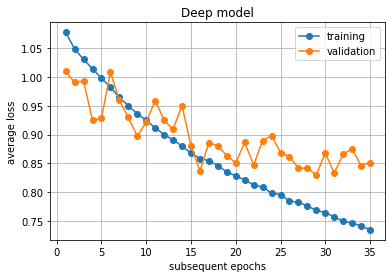

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Deep().to(device)

optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'])
                      #weight_decay=1.e-3)
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'Deep model')

In [ ]:
nb_classes = 3
DEVICE =device
import numpy as np
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(DEVICE)
        classes = classes.to(DEVICE)
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

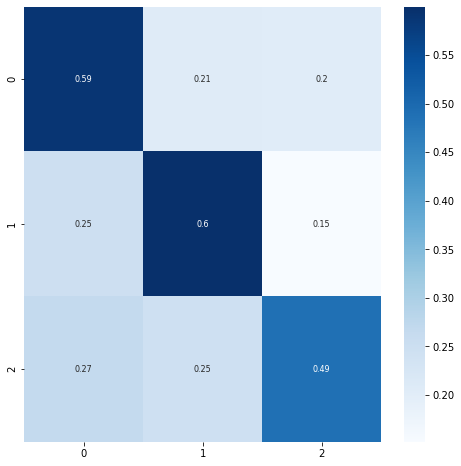

In [ ]:
import seaborn as sns
new_matrix = [[] for row in confusion_matrix]
i=0
for row in confusion_matrix:
  for j in row:
    new_matrix[i].append(j/sum(row))
  i+=1
  
plt.figure(figsize =(8,8))
sns.heatmap(new_matrix, annot=True, cmap="Blues", annot_kws={"fontsize":8})

In [ ]:
from torchsummary import summary
print(summary(model,(1, 96)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 60]           5,820
           Dropout-2                   [-1, 60]               0
            Linear-3                   [-1, 20]           1,220
           Dropout-4                   [-1, 20]               0
            Linear-5                    [-1, 3]              63
Total params: 7,103
Trainable params: 7,103
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------
None


In [ ]:
from sklearn import svm
svc = svm.SVC(class_weight='balanced')
y_model1 = svc.fit(X_train, y_train)
y_pred = y_model1.predict(X_test)
calculate_accuracy(y_pred, y_test, comment='balanced SVM classifier')

svc = svm.SVC(class_weight='balanced')
X_new_train = [np.array([y_model1.predict([i]), np.mean(i)]) for i in X_train]
y_model2 = scv.fit(X_new_train, y_train)
y_pred = y_model2.predict(X_test)
calculate_accuracy(y_pred, y_test, comment='new balanced SVM classifier')

-----------------------------------
balanced SVM classifier
Total accuracy, Acc_T = 0.6633
Arrhythmia accuracy, Acc_A = 0.4382
-----------------------------------


Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, 

NameError: ignored

In [ ]:
y_model1.predict([X_train[0]])
#X_new_train = [np.array([y_model1.predict(i), np.mean(i)]) for i in X_train]

array(['N'], dtype='<U1')

###################### Koniec mojego z adabostem

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='naive Bayes classifier')

svc = svm.SVC()
y_pred = svc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='SVM classifier')

svc = svm.SVC(class_weight='balanced')
y_pred = svc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='balanced SVM classifier')

-----------------------------------
naive Bayes classifier
Total accuracy, Acc_T = 0.7788
Arrhythmia accuracy, Acc_A = 0.1573
-----------------------------------
-----------------------------------
SVM classifier
Total accuracy, Acc_T = 0.8875
Arrhythmia accuracy, Acc_A = 0.0550
-----------------------------------
-----------------------------------
balanced SVM classifier
Total accuracy, Acc_T = 0.6466
Arrhythmia accuracy, Acc_A = 0.4855
-----------------------------------


Summary of this part:
1. The goal is to maximize both metrics Acc_T and Acc_A at the same time
1. naive Bayes performs rather poorly
> - problem with data imbalace
2. SVM has simillar problem, but after data balacing works quite good

-----------------------------------
balanced DT
Total accuracy, Acc_T = 0.6301
Arrhythmia accuracy, Acc_A = 0.3374
-----------------------------------
0.04524886877828054
0.30165912518853694
0.5188536953242836
0.5490196078431373
0.6847662141779789
0.48114630467571645
0.5957767722473605
0.5052790346907994
0.42835595776772245
0.49019607843137253
0.47058823529411764
0.416289592760181
0.4238310708898944
0.4479638009049774
0.4117647058823529
0.41025641025641024
0.40120663650075417
0.38310708898944196
0.3815987933634992
0.358974358974359
0.35294117647058826
0.34238310708898945
0.33031674208144796
0.334841628959276
0.3273001508295626


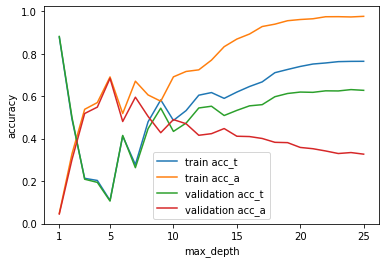

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion='entropy', 
                             class_weight='balanced', 
                             min_samples_leaf=10)
y_pred = dtc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='balanced DT')

# tunning max_dept hyperparameter (DT likes to overfit)
train_acc_t = []
train_acc_a = []
val_acc_t = []
val_acc_a = []
depth_range = range(1,26)
for max_depth in depth_range:
    dtc = DecisionTreeClassifier(criterion='entropy', 
                                 class_weight='balanced', 
                                 min_samples_leaf=10,
                                 max_depth=max_depth)
    dt_fit = dtc.fit(X_train, y_train)
    y_pred_train = dt_fit.predict(X_train)
    y_pred_val = dt_fit.predict(X_val)    
    acc_t_train, acc_a_train = calculate_accuracy(y_pred_train, y_train, printout=False)
    acc_t_val, acc_a_val = calculate_accuracy(y_pred_val, y_val, printout=False)
    train_acc_t.append(acc_t_train)
    train_acc_a.append(acc_a_train)
    val_acc_t.append(acc_t_val)
    val_acc_a.append(acc_a_val)
    print(acc_a_val)

import matplotlib.pyplot as plt
_, ax = plt.subplots()
ax.plot(depth_range, train_acc_t, label='train acc_t')
ax.plot(depth_range, train_acc_a, label='train acc_a')
ax.plot(depth_range, val_acc_t, label='validation acc_t')
ax.plot(depth_range, val_acc_a , label='validation acc_a')
ax.set(xlabel='max_depth', ylabel='accuracy')
ax.xaxis.set_ticks([1, 5, 10, 15, 20, 25])
ax.legend()
plt.show()

In [ ]:
# optimum acc_a max_depth
dtc = DecisionTreeClassifier(criterion='entropy', 
                             class_weight='balanced',
                             min_samples_leaf=10,
                             max_depth=8)
y_pred = dtc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='DT: Acc_A maximized')

# optimum acc_t & acc_a max_depth
dtc = DecisionTreeClassifier(criterion='entropy', 
                             class_weight='balanced',
                             min_samples_leaf=10,
                             max_depth=13)
y_pred = dtc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='DT: Acc_T + Acc_A maximized')

-----------------------------------
DT: Acc_A maximized
Total accuracy, Acc_T = 0.4514
Arrhythmia accuracy, Acc_A = 0.5450
-----------------------------------
-----------------------------------
DT: Acc_T + Acc_A maximized
Total accuracy, Acc_T = 0.5497
Arrhythmia accuracy, Acc_A = 0.4366
-----------------------------------


In [ ]:
# feature vector via PCA (dimensionlality reduction) works poorly
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
X_train_ = pca.fit_transform(X_train)
X_test_ = pca.fit_transform(X_test)

dtc = DecisionTreeClassifier(criterion='entropy', 
                             class_weight='balanced', 
                             min_samples_leaf=5,
                             max_depth=8)
y_pred = dtc.fit(X_train_, y_train).predict(X_test_)
calculate_accuracy(y_pred, y_test, comment='DT with PCA')

-----------------------------------
DT with PCA
Total accuracy, Acc_T = 0.3628
Arrhythmia accuracy, Acc_A = 0.4168
-----------------------------------


Summary:
1. Decision Tree works a bit worse (than SVM) and has tendency to overfit. We consider two types of hyperparameters:
> - *max_depth*
> - *min_samples_leaf*
2. Tunning *max_depth* gives Acc_A (*max_depth*=8), or Acc_T & Acc_A (*max_depth*=13) maximum value
3. Simple dimensionality reduction using PCA works rather poorly

In [ ]:
import pywt
from sklearn.tree import DecisionTreeClassifier

# extract features using different wavelets and simple differences
def extract_features(input_sample):
    out = np.array([])
# sym8
    cA = pywt.downcoef('a', input_sample, 'sym8', level=4, mode='per')
    out = np.append(out,cA)
    cD = pywt.downcoef('d', input_sample, 'sym8', level=4, mode='per')
    out = np.append(out,cD)
# db6/9
    cA = pywt.downcoef('a', input_sample, 'db6', level=4, mode='per')
    out = np.append(out,cA)
    cD = pywt.downcoef('d', input_sample, 'db6', level=4, mode='per')
    out = np.append(out,cD)
    cA = pywt.downcoef('a', input_sample, 'db9', level=4, mode='per')
    out = np.append(out,cA)
    cD = pywt.downcoef('d', input_sample, 'db9', level=4, mode='per')
    out = np.append(out,cD)
# dmey
    cA = pywt.downcoef('a', input_sample, 'dmey', level=4, mode='per')
    out = np.append(out,cA)
    cD = pywt.downcoef('d', input_sample, 'dmey', level=4, mode='per')
    out = np.append(out,cD)

# differences
    differences = np.zeros(16)
    for i, t in enumerate(range(40, 56)):
        differences[i] = input_sample[t+1]-input_sample[t]
    out = np.append(out,differences)
    return out

# collect vector of features for all samples
def data_features(input_data):
    return np.array([extract_features(sample) for sample in input_data])

X_train_ = data_features(X_train)
print(X_train_.shape)
X_test_ = data_features(X_test)
print(X_test_.shape)

dtc = DecisionTreeClassifier(criterion='entropy', 
                             class_weight='balanced', 
                             min_samples_leaf=10,
                             max_depth=8)
y_pred = dtc.fit(X_train_, y_train).predict(X_test_)
calculate_accuracy(y_pred, y_test, comment='DT with wavelets')

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(criterion='entropy', 
                             n_estimators=1000, 
                             max_depth=8, 
                             class_weight='balanced')
y_pred = rfc.fit(X_train_, y_train).predict(X_test_)
calculate_accuracy(y_pred, y_test, comment='RF with wavelets')

from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(n_estimators=200)
y_pred = abc.fit(X_train_, y_train).predict(X_test_)
calculate_accuracy(y_pred, y_test, comment='Ada with wavelets')

(25718, 64)
(5512, 64)
-----------------------------------
DT with wavelets
Total accuracy, Acc_T = 0.3527
Arrhythmia accuracy, Acc_A = 0.5954
-----------------------------------


KeyboardInterrupt: ignored

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(n_estimators=200, learning_rate=5.0)
y_pred = abc.fit(X_train_, y_train).predict(X_test_)
calculate_accuracy(y_pred, y_test, comment='Ada with wavelets')

-----------------------------------
Ada with wavelets
Total accuracy, Acc_T = 0.0624
Arrhythmia accuracy, Acc_A = 0.5252
-----------------------------------


# Tasks to do 
1. Compare results for Random Forest with AdaBoost classifier (try to figure out why the default Ada setup won't work, how to fix this problem)
2. Add deep-neural classifier (like one in previous lab) and compare its preformance with today's best classifier
3. Modify classifier to get **accuracy > 0.57** for both Acc_T *and* Acc_A
> - play with classifier hyperparameters
> - add some other features, e.g:
>> - [mean of absolute value (MAV) of signal](https://www.researchgate.net/publication/46147272_Sequential_algorithm_for_life_threatening_cardiac_pathologies_detection_based_on_mean_signal_strength_and_EMD_functions)
>> - signal energy/entropy
>> - some other signal features from [scipy signal](https://docs.scipy.org/doc/scipy/reference/signal.html#peak-finding), 
>> - **in case of troubles:** distances between previous and next heartbeats are strong features, see e.g. [here](https://link.springer.com/article/10.1007/s11760-009-0136-1),
>> - it may be also usefull to perform some feature selection, e.g. choose these with variance higher than some assumed threshold.
>> - *intuition*: variance measures amount of information in a given feature
> - or build your own classifier (e.g. deep-neural-like) 